I wanted to make a Time Series Forecast Analysis of Take-Two Interactive Software, Inc. (TTWO) for the last 9 years (from 1/1/2010 to 1/1/2020) Data taken from https://finance.yahoo.com/

In [113]:
from datetime import datetime
import pandas as pd
import numpy as np


# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Setting default figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


# Forecasting Imports
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima
from pmdarima.arima import auto_arima


# Math/Error metrics imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [72]:
# Loading CSV file with index as date
df = pd.read_csv('finance.yahoo.com-TTWO.csv',index_col='Date',parse_dates= True)
# Dropping columns not needed
TTWO = df.drop(columns= ['Open','High','Low','Close','Volume'])

In [73]:
# Displaying dataframe
TTWO.info()
TTWO

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
Adj Close    2516 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


,Adj Close
Date,
2010-01-04,10.400000
2010-01-05,10.470000
2010-01-06,10.440000
2010-01-07,10.390000
2010-01-08,10.420000
...,...
2019-12-24,123.930000
2019-12-26,123.989998
2019-12-27,124.470001


In [74]:
# Checking if the datetime is index values
TTWO.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [75]:
# Aaggregating the data by month (averaging the values by month)
TTWO_weekly =TTWO.resample('W').mean()
# Displaying dataframe
TTWO_weekly

,Adj Close
Date,
2010-01-10,10.424000
2010-01-17,10.292000
2010-01-24,9.585000
2010-01-31,9.242000
2010-02-07,9.364000
...,...
2019-12-08,122.700001
2019-12-15,122.368000
2019-12-22,122.634000


In [76]:
# Aaggregating the data by month (averaging the values by month)
TTWO_monthly =TTWO.resample('MS').mean()
# Displaying dataframe
TTWO_monthly

,Adj Close
Date,
2010-01-01,9.901579
2010-02-01,9.486316
2010-03-01,10.031304
2010-04-01,10.668571
2010-05-01,10.766000
...,...
2019-08-01,128.260908
2019-09-01,128.281000
2019-10-01,122.262609


In [77]:
# Aaggregating the data by month (averaging the values by month)
TTWO_annually =TTWO.resample('Y').mean()
# Displaying dataframe
TTWO_annually

,Adj Close
Date,
2010-12-31,10.282659
2011-12-31,14.374405
2012-12-31,12.280920
2013-12-31,16.176190
2014-12-31,22.067897
2015-12-31,29.267302
2016-12-31,40.248532
2017-12-31,80.860159
2018-12-31,115.897530


In [78]:
yearly = TTWO_monthly.groupby(pd.Grouper(freq ='A'))
yearly.describe()
# yearly.head()

Adj Close                                                \
               count        mean        std        min         25%   
Date                                                                 
2010-12-31      12.0   10.275100   0.843548   9.000455    9.810833   
2011-12-31      12.0   14.386680   1.308214  11.916087   13.640714   
2012-12-31      12.0   12.308719   2.384168   9.181905   10.558716   
2013-12-31      12.0   16.155247   1.660358  12.361429   15.492977   
2014-12-31      12.0   22.053001   2.873569  17.893809   20.500357   
2015-12-31      12.0   29.245201   3.316590  24.873809   27.362658   
2016-12-31      12.0   40.185929   5.373694  33.342105   36.077630   
2017-12-31      12.0   80.625733  22.300738  51.733000   59.634136   
2018-12-31      12.0  115.752131  10.267440  98.018095  110.683497   
2019-12-31      12.0  111.607943  13.554261  92.666667  101.390910   

                                                
                   50%         75%         max  
Date                                            
2010-12-31   10.112016   10.692929   12.190909  
2011-12-31   14.477083   15.351076   16.277143  
2012-12-31   11.915988   14.665750   15.750455  
2013-12-31   16.149545   17.365098   18.424545  
2014-12-31   21.572143   22.909865   27.820000  
2015-12-31   28.993191   30.462500   35.638636  
2016-12-31   38.961955   44.600119   49.323809  
2017-12-31   76.012318  101.040568  114.777143  
2018-12-31  115.102857  123.900435  133.108422  
2019-12-31  114.602931  122.385052  128.281000

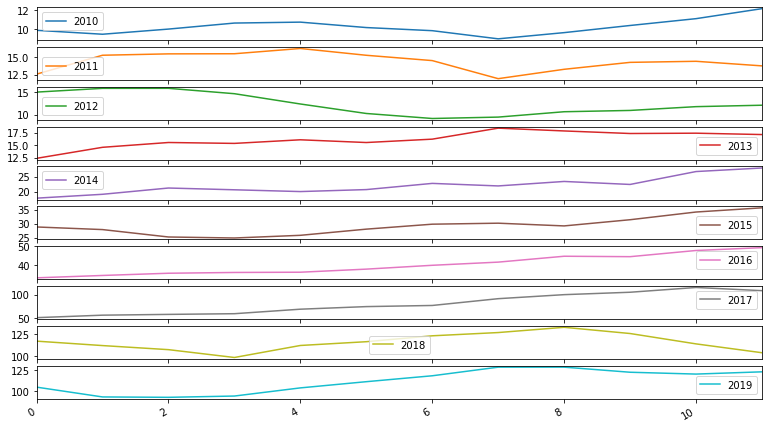

In [104]:
# Create a new DataFrame and store yearly values in columns 
TTWO_annual = pd.DataFrame()

# For loop to group each year separately amd adding it to empty dataframe
for yr, group in yearly:
    TTWO_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
TTWO_annual.plot(figsize = (13,8), subplots=True, legend=True);

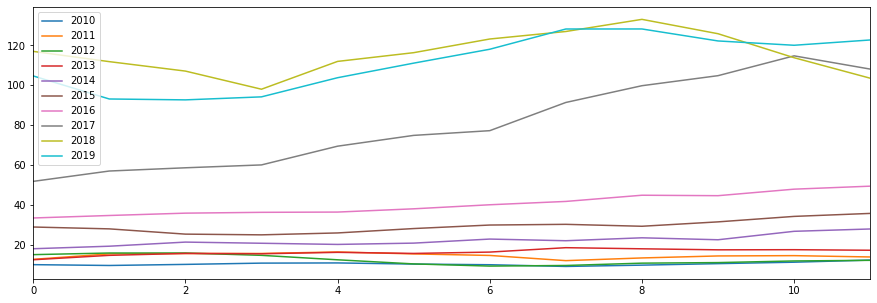

In [105]:
# Plot overlapping yearly groups 
TTWO_annual.plot(figsize = (15,5), subplots=False, legend=True,grid=False);

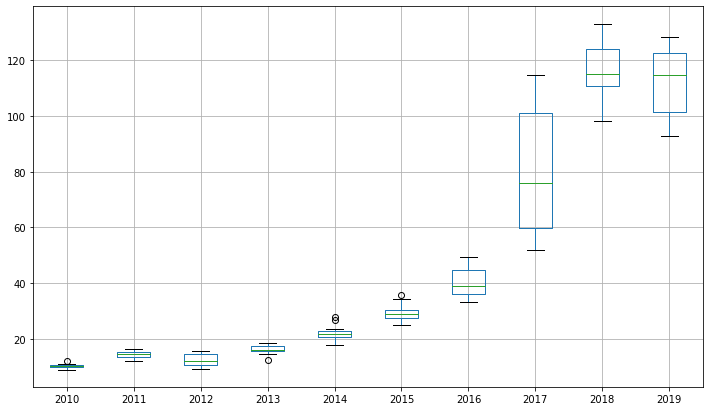

In [106]:
TTWO_annual.boxplot(figsize = (12,7));

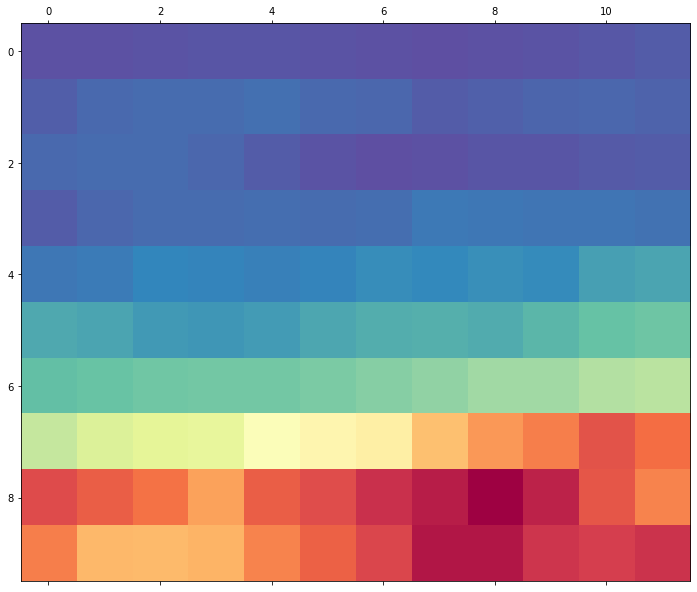

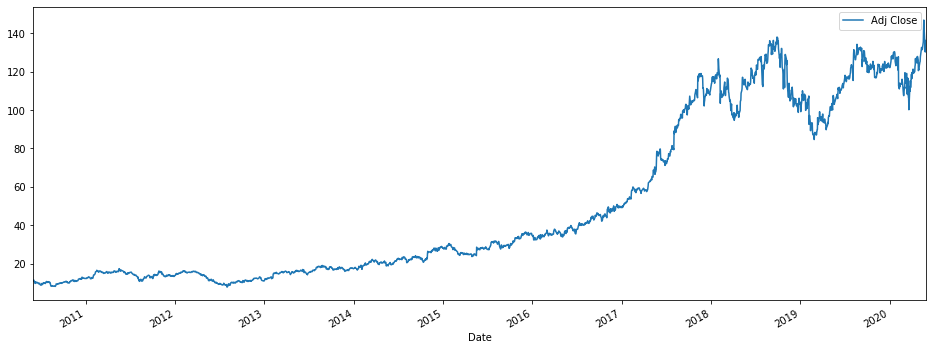

In [21]:
TTWO.plot(figsize = (16,6));

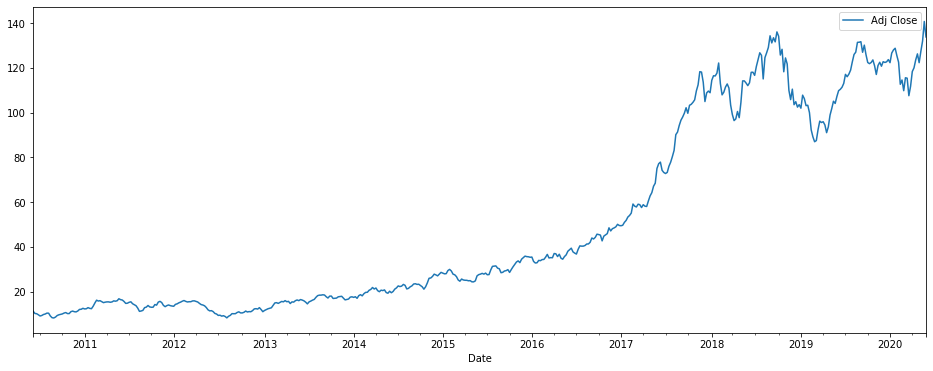

In [25]:
TTWO_weekly.plot(figsize = (16,6));

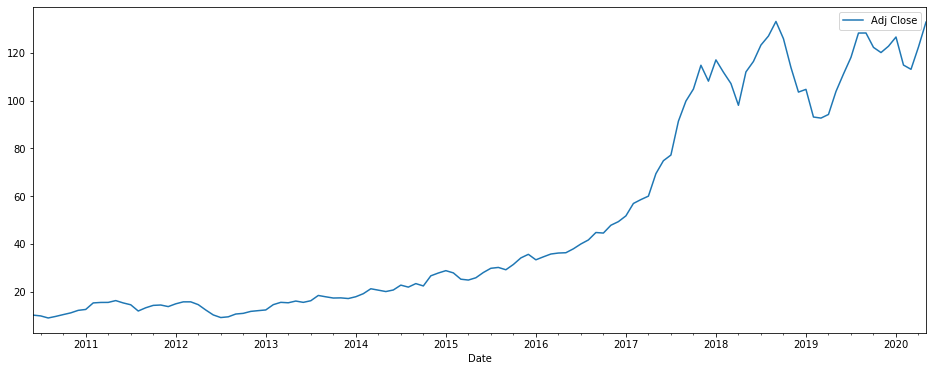

In [20]:
TTWO_monthly.plot(figsize = (16,6));

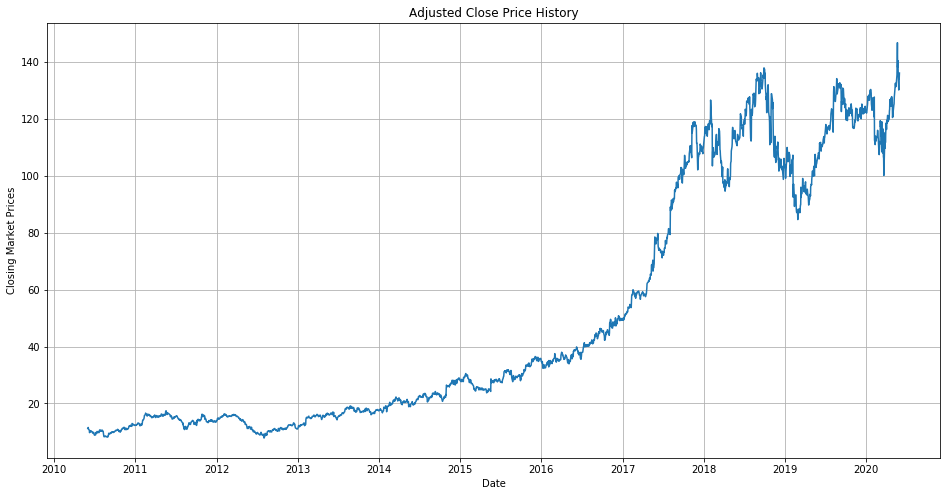

In [12]:
# Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Adjusted Close Price History')
plt.plot(TTWO['Adj Close'])
plt.show()

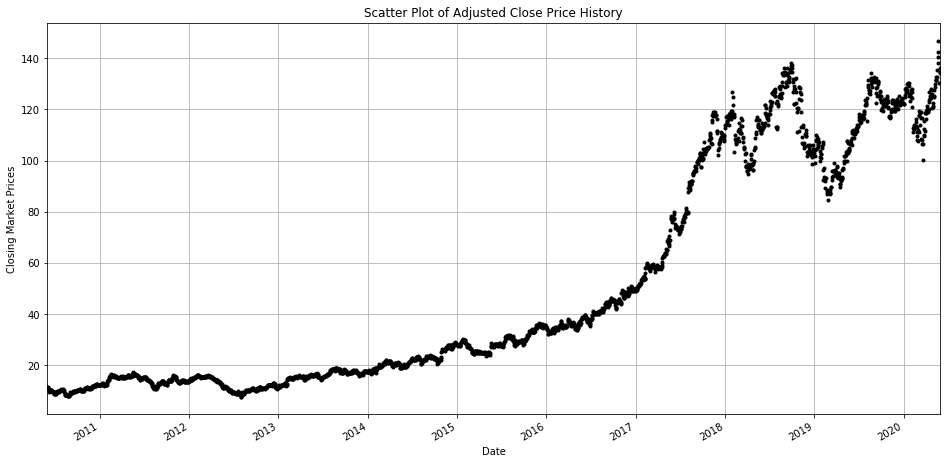

In [19]:
# Scatter Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
TTWO['Adj Close'].plot(style='k.',)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Scatter Plot of Adjusted Close Price History')
plt.show() 

In [95]:
# Filtering DataFrames to only include dates from 2015
TTWO_filtered = TTWO.loc['2015-01-01':]

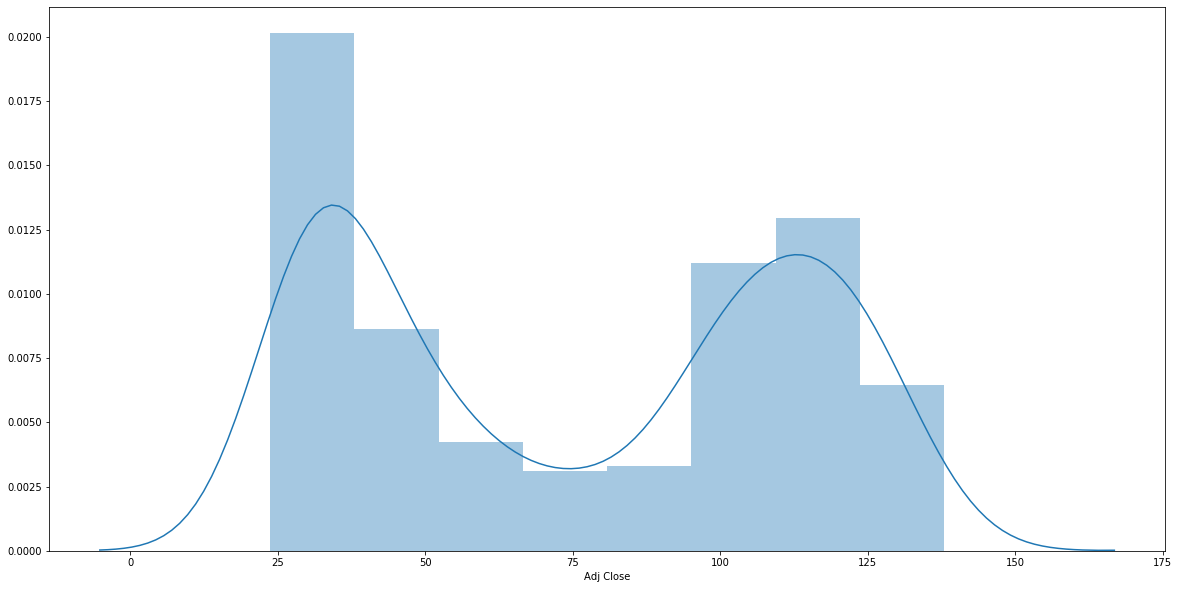

In [102]:
sns.distplot(TTWO_filtered['Adj Close'], hist=True, kde=True,bins=8)

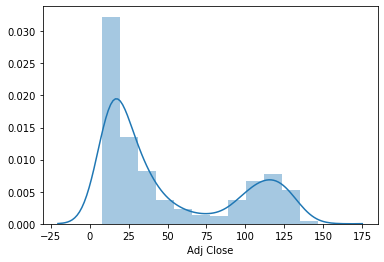

In [16]:
sns.distplot(TTWO['Adj Close'], hist=True, kde=True)

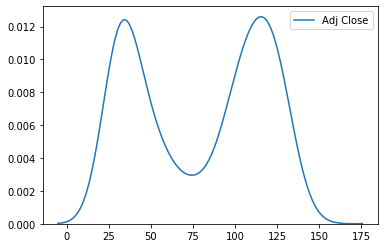

In [17]:
sns.kdeplot(TTWO_filtered['Adj Close'])

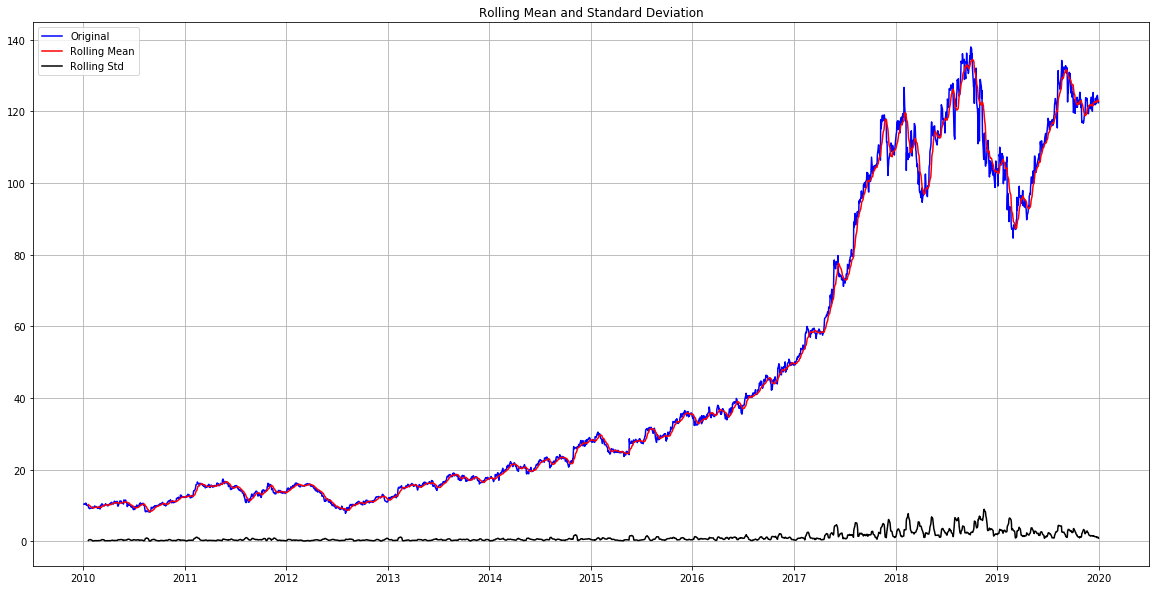

Results of Augmented Dickey Fuller(ADF) Test:
Test Statistics                   0.273045
p-value                           0.976073
No. of Lags Used                 27.000000
Number of observations used    2488.000000
critical value (1%)              -3.432981
critical value (5%)              -2.862702
critical value (10%)             -2.567389
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Test Statistic            7.552696
p-value                   0.010000
No. of Lags Used         27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [121]:
# Testing for staionarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Augmented Dickey Fuller Test (Most commonly used)
    print("Results of Augmented Dickey Fuller(ADF) Test:")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    adft_output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of Lags Used','Number of observations used'])
    for key,values in adft[4].items():
        adft_output['critical value (%s)'%key] =  values
    print(adft_output)
    
    # Kwiatkowski-Phillips-Schmidt-Shin Test (Less commonly used)
    print ('\n\nResults of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
test_stationarity(TTWO['Adj Close'])

Dicktest statistic greater then critical value, which implies that the time series is not stationary
p-value is almost at 1.0 showing again that the time series is not stationary

C:\Users\sdman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


<Figure size 1440x720 with 0 Axes>

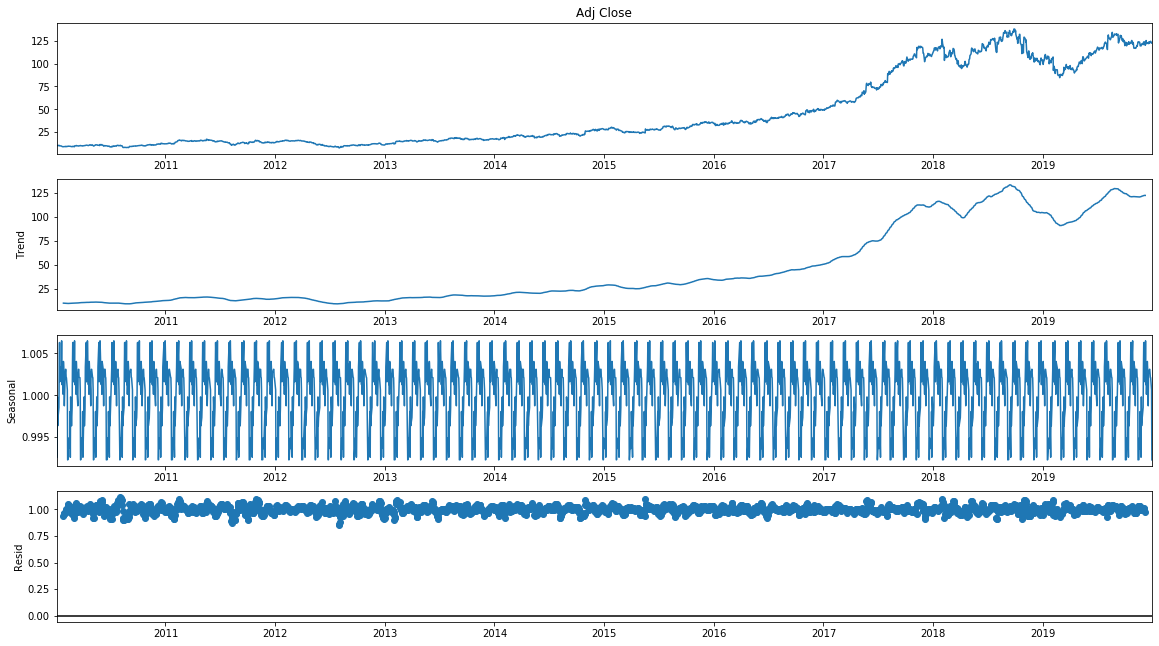

In [110]:
# Separating seasonality and trend
result = seasonal_decompose(TTWO['Adj Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

The trend is showing a Exponential upward trend (generally)
The seasonality looks to be broken down bi-quarterly(or 1.5 months)